In [ ]:
import re
import json
import matplotlib.pyplot as plt
import numpy as np
from math import ceil
import subprocess
import shlex

In [ ]:
working_dirs = [ ('master with cgroup', '../withcg-master'), ('segment with cgroup', '../withcg-segment'), 
                ('master without cgroup', '../withoutcg-master'), ('segment without cgroup','../withoutcg-segment')]

In [ ]:
def generate_process_name(out_file):
    pattern = r"^ *(?P<pid>\d+) +be\/\d [\w_-]+ +\d+\.\d+ K?B?M?\/s *(?P<wspeed>\d+\.\d+) (?P<wunit>K?B?M?)\/s +\d+\.\d+ % +\d+\.\d+ % (?P<pname>postgres:.*\(\d+\)).*$"
    pattern_for_others = r"^ *(?P<pid>\d+) +be\/\d [\w_-]+ +\d+\.\d+ K?B?M?\/s *(?P<wspeed>\d+\.\d+) (?P<wunit>K?B?M?)\/s +\d+\.\d+ % +\d+\.\d+ % (?P<pname>postgres:.*)$"
    
    results = {}
    with open(out_file) as f:
        count = 0
        for line in f:
            r = re.match(pattern, line) or re.match(pattern_for_others, line)
            if r:
                results[int(r['pid'])] = r['pname']
                
    return results

In [ ]:
def plot_iotop_per_process(name, out_dir):
    patter_for_qe = r"^ *(?P<pid>\d+) +be\/\d [\w_-]+ +\d+\.\d+ K?B?M?\/s *(?P<wspeed>\d+\.\d+) (?P<wunit>K?B?M?)\/s +\d+\.\d+ % +\d+\.\d+ % (?P<pname>postgres:.*\(\d+\)).*$"
    pattern_for_others  = r"^ *(?P<pid>\d+) +be\/\d [\w_-]+ +\d+\.\d+ K?B?M?\/s *(?P<wspeed>\d+\.\d+) (?P<wunit>K?B?M?)\/s +\d+\.\d+ % +\d+\.\d+ % (?P<pname>postgres:.*)$"
    pattern_start = r"  TID  PRIO  USER     DISK READ  DISK WRITE  SWAPIN      IO    COMMAND"
    
    pid_of_sum_qe = '0'
    
    with open(out_dir + "/process_name.json", 'r') as f:
        pname = json.load(f)
        pname[pid_of_sum_qe] = "sum of QE/QD"
    write_speed_result = {}
    write_unit = 'K'
    with open(out_dir + "/iotop/output") as f:
        record_start = False
        sum_of_qe = 0
        for line in f:
            r = re.match(pattern_start, line)
            if r:
                if record_start:
                    if pid_of_sum_qe not in write_speed_result.keys():
                        write_speed_result[pid_of_sum_qe] = [sum_of_qe]
                    else:
                        write_speed_result[pid_of_sum_qe].append(sum_of_qe)
                record_start = True
                sum_of_qe = 0
                continue

            
            if record_start:
                r = re.match(patter_for_qe, line)
                if r:
                    wspeed = float(r['wspeed'])
                    wunit = r['wunit']
                
                    if wunit == 'M':
                        wspeed = wspeed * 1000
                    elif wunit == 'B':
                        wspeed = wspeed / 1000
                    
                    sum_of_qe = sum_of_qe + wspeed
                else:
                    r = re.match(pattern_for_others, line)
                    if r:
                        wspeed = float(r['wspeed'])
                        wunit = r['wunit']
                
                        if wunit == 'M':
                            wspeed = wspeed * 1000
                        elif wunit == 'B':
                            wspeed = wspeed / 1000
                    
                        if r['pid'] not in write_speed_result.keys():
                            write_speed_result[r['pid']] = [wspeed]
                        else:
                            write_speed_result[r['pid']].append(wspeed)
    count = 0
    total_figures = len(write_speed_result.keys())
    fig, ax = plt.subplots(ceil(total_figures / 3), 3, figsize=(18,15 ))
    fig.suptitle("iotop of " + name, fontsize=14)
    for k in write_speed_result.keys(): 
        ax[int(count / 3), count - 3 * int(count / 3)].plot(np.linspace(1, len(write_speed_result[k]), len(write_speed_result[k])), write_speed_result[k], label = pname[k])
        
        ax[int(count / 3), count - 3 * int(count / 3)].set_xlabel('times')
        ax[int(count / 3), count - 3 * int(count / 3)].set_ylabel('KB')
        ax[int(count / 3), count - 3 * int(count / 3)].legend()
        
        count = count + 1
    
    fig.savefig("iotop of " + name + ".png")
            
    

In [51]:
# plot iostat figure
def plot_iostat_figure(working_dirs):
    pattern = r"^\w+ +\d+\.\d+ +(?P<rspeed>\d+\.\d+) +(?P<wspeed>\d+\.\d+) +\d+ + \d+$"
    
    fig, ax = plt.subplots()
    for item in working_dirs:
        result = []
        with open(item[1] + "/iostat/output", 'r') as f:
            for line in f:
                r = re.match(pattern, line)
                
                if r:
                    result.append(float(r['wspeed']) / 1000)
        ax.plot(np.linspace(1, len(result), len(result)), result, label = item[0])

    ax.set_xlabel('times')
    ax.set_ylabel('MB/s')
    ax.set_title("iostat write speed")
    ax.legend()
    fig.savefig("iostat.png")

In [60]:
# plot blktrace
def plot_blktrace_data(name, out_dir):
    #format.out produced by "blkparse -i sdb -a queue -f '%C %p %N %8s %2a %3d\n' | grep 'postgres' | grep G > format.out"
    format_outfile = out_dir + "/blktrace/format.out"
    with open(out_dir + "/process_name.json", 'r') as f:
        pname = json.load(f)
    
    total = {}
    with open(format_outfile, 'r') as f:
        for line in f:
            datas = line.split(' ')
    
            pid = datas[1]
            bytes_ = int(datas[2])
            
            if pid not in total:
                total[pid] = 0
            
            total[pid] = total[pid] + bytes_
    
    for k in total.keys():
        total[k] = total[k] / 1024
    
    x_labels = []
    y_labels = []
    count = 0 
    for k in total.keys():
        x_labels.append(pname[k])
        y_labels.append(total[k])
    
    fig, ax = plt.subplots(figsize=(18,24 ))
    ax.bar(x_labels,y_labels)
    labels = ax.get_xticklabels()
    plt.setp(labels, rotation=45, horizontalalignment='right')

    ax.set_xlabel("process name")
    ax.set_ylabel("total write/KB")
    ax.set_title("blkio trace of " + name)
    for p in ax.patches:
        ax.annotate(str(round(p.get_height(),2)), (p.get_x() * 1.000, p.get_height() * 1.005),color='red')
    
    fig.savefig("blktrace of " + name)


    

In [ ]:
# generate process name of pids
for dir in working_dirs:
    results = generate_process_name(dir[1] + "/iotop/output")
    with open(dir[1] + "/process_name.json", "w+") as f:
        f.write(json.dumps(results))

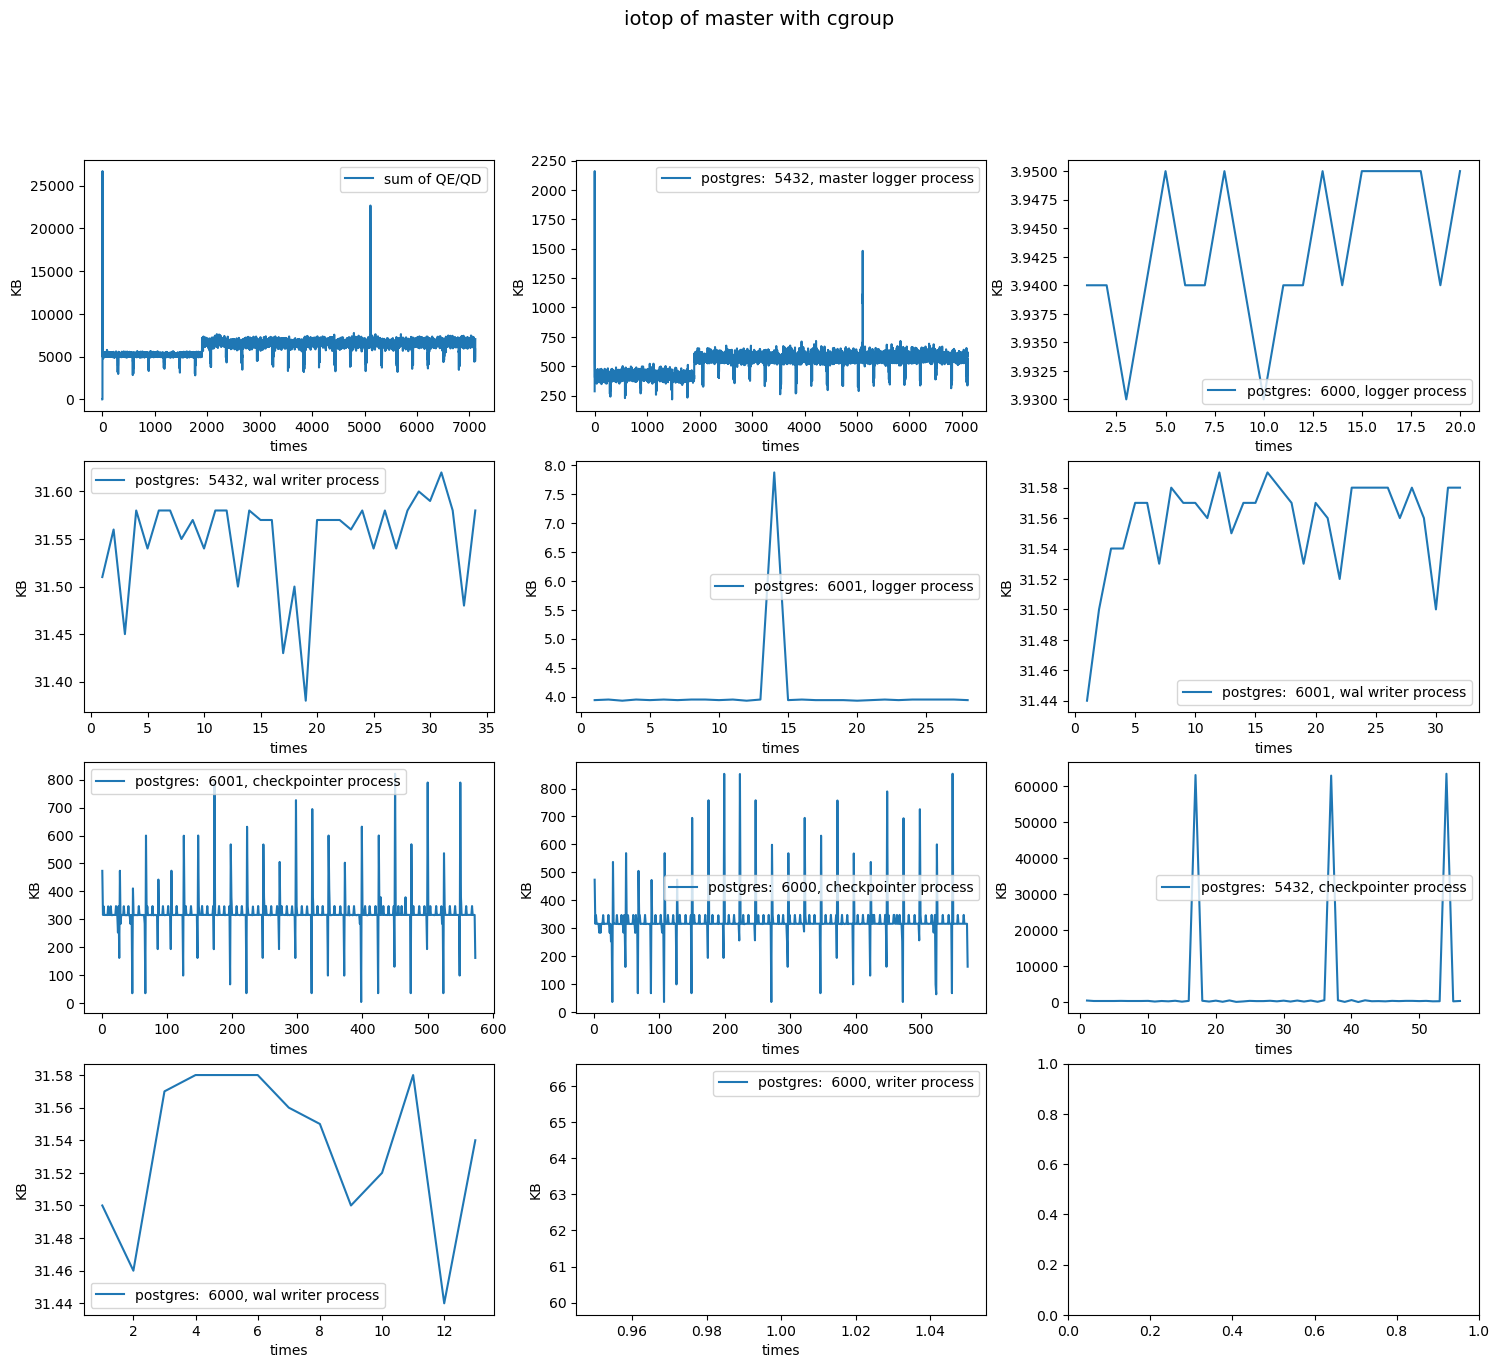

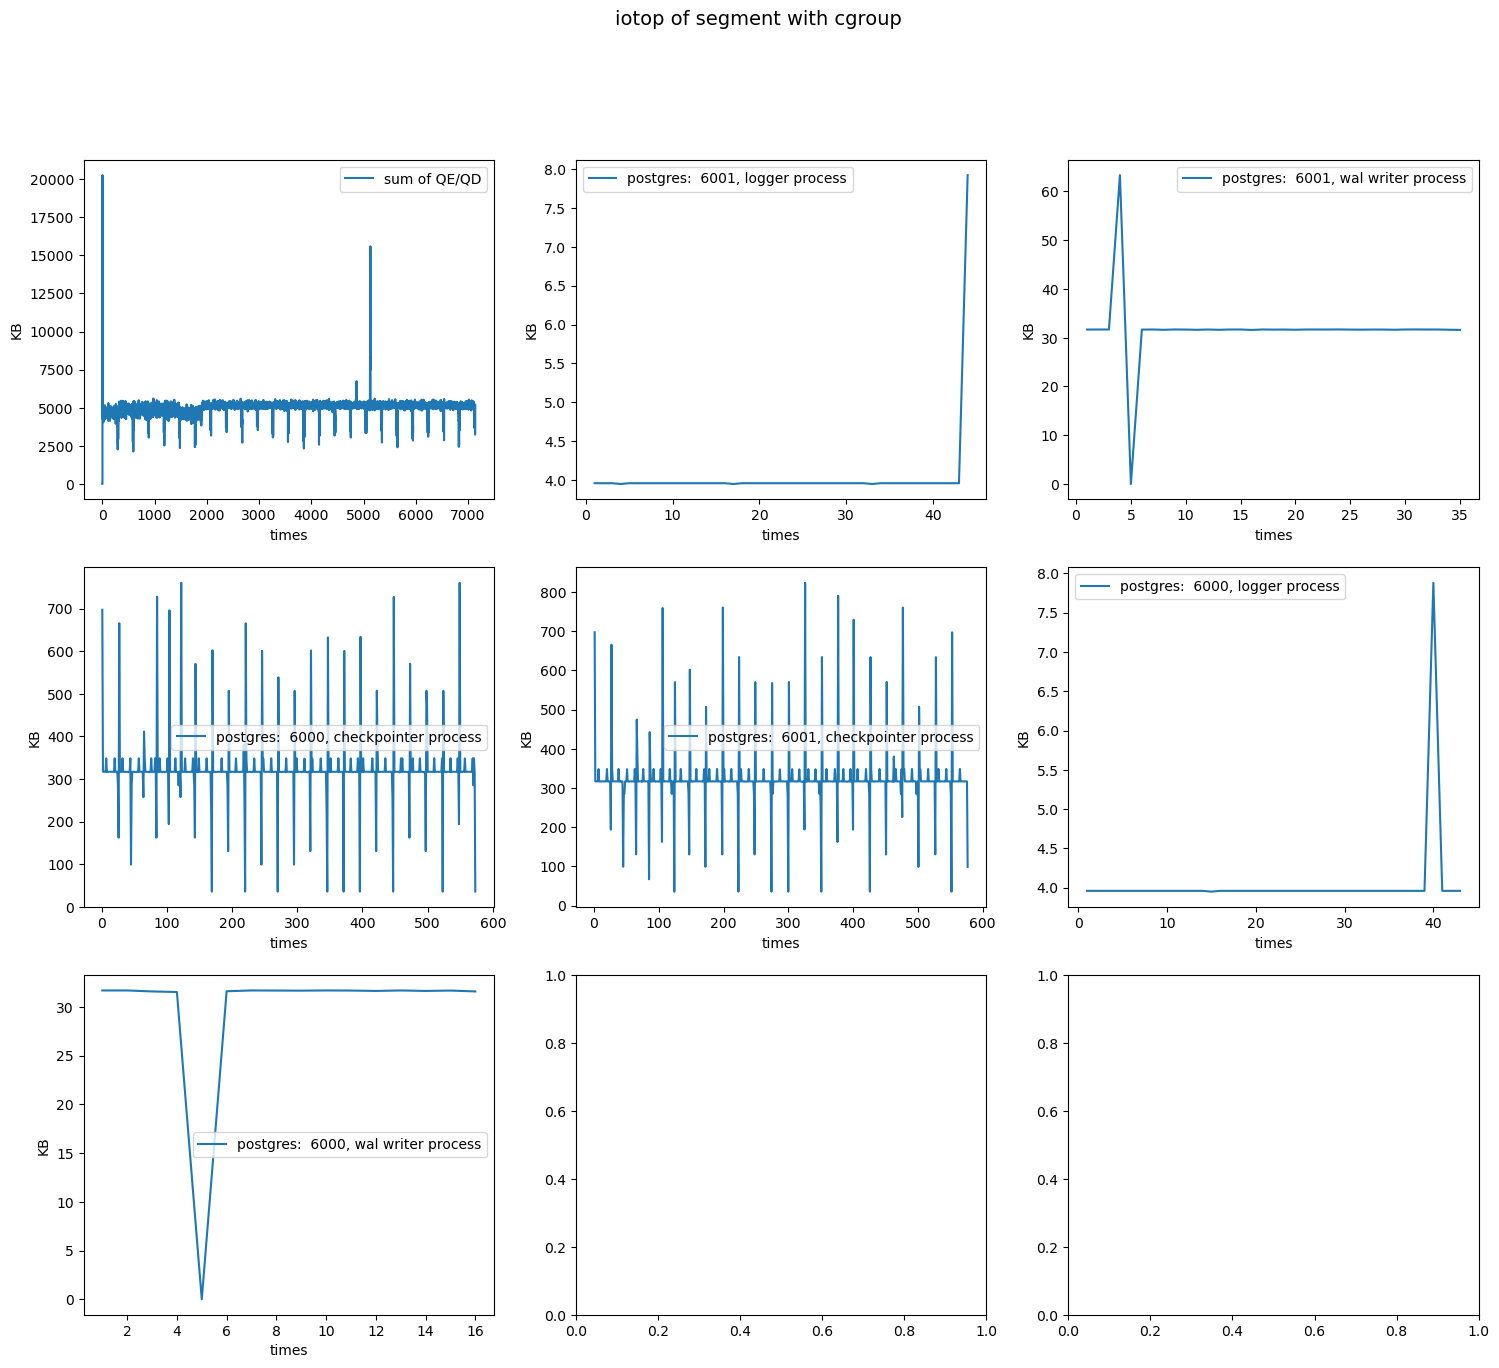

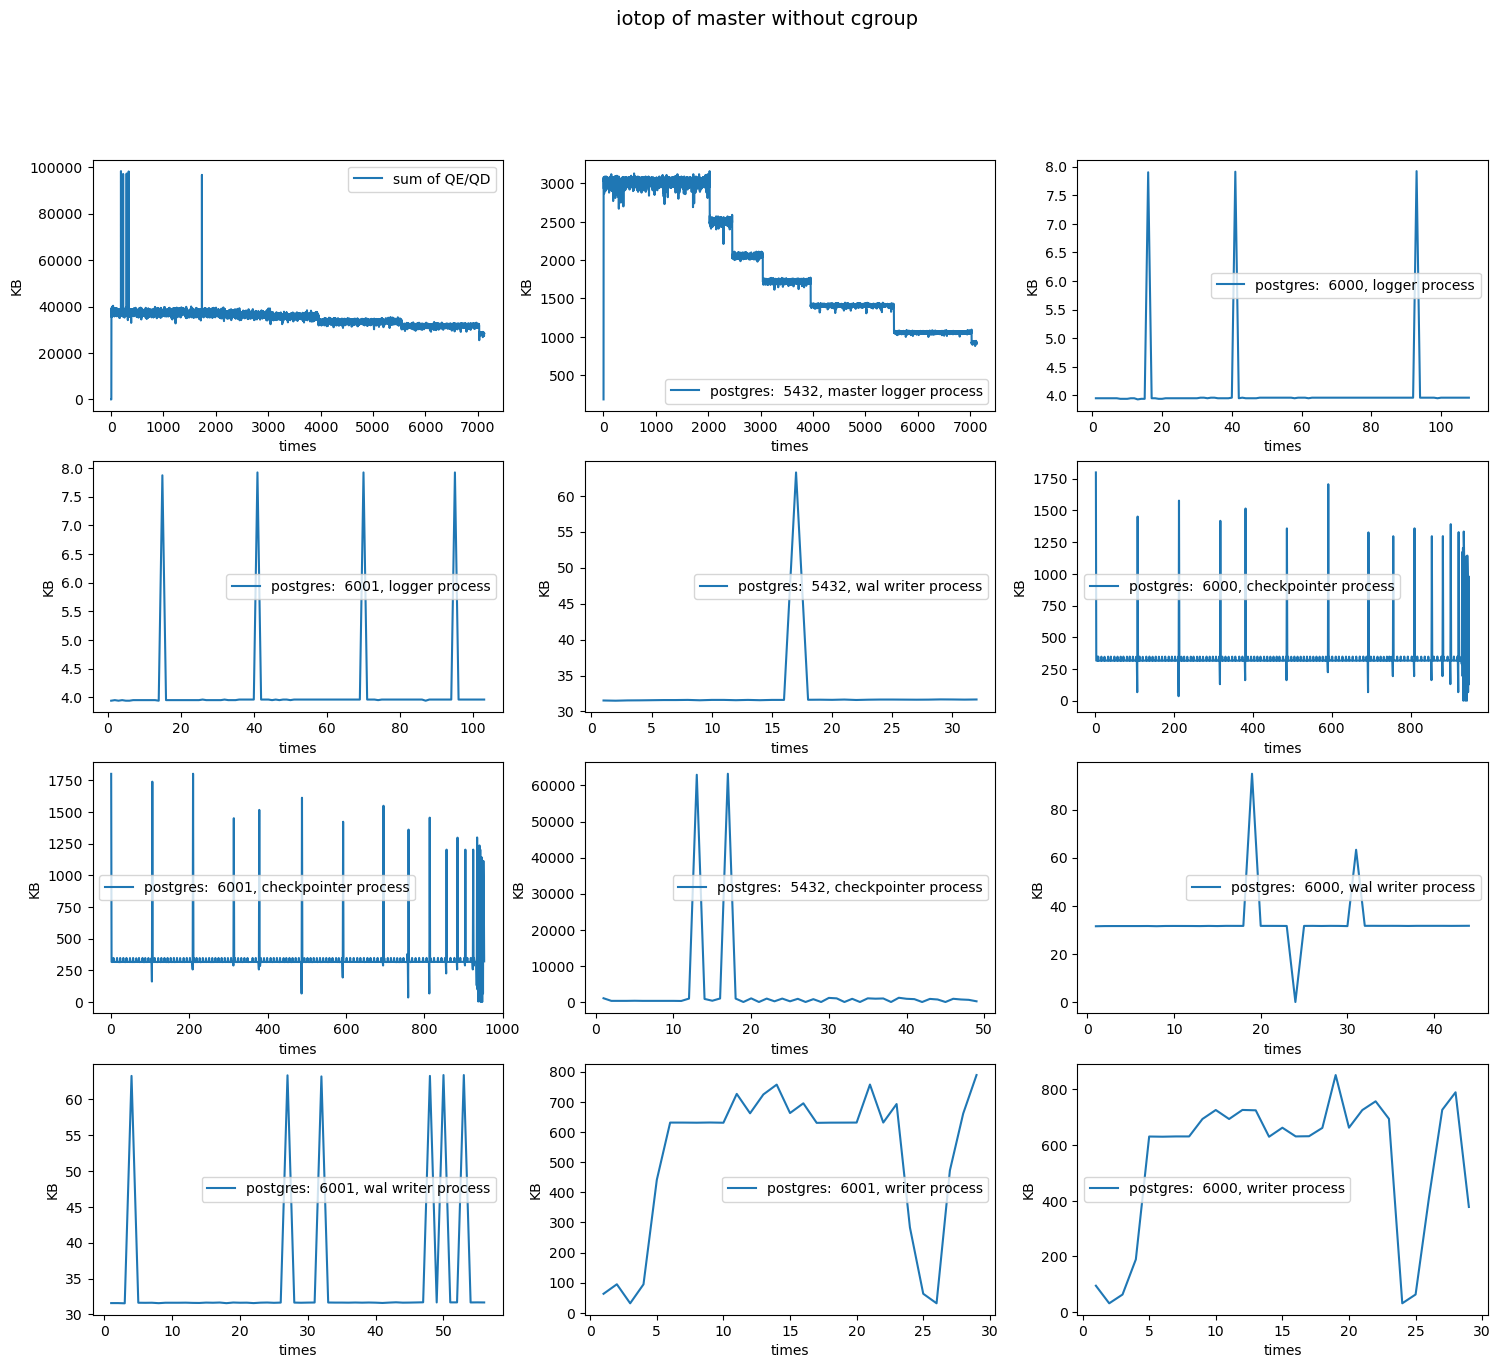

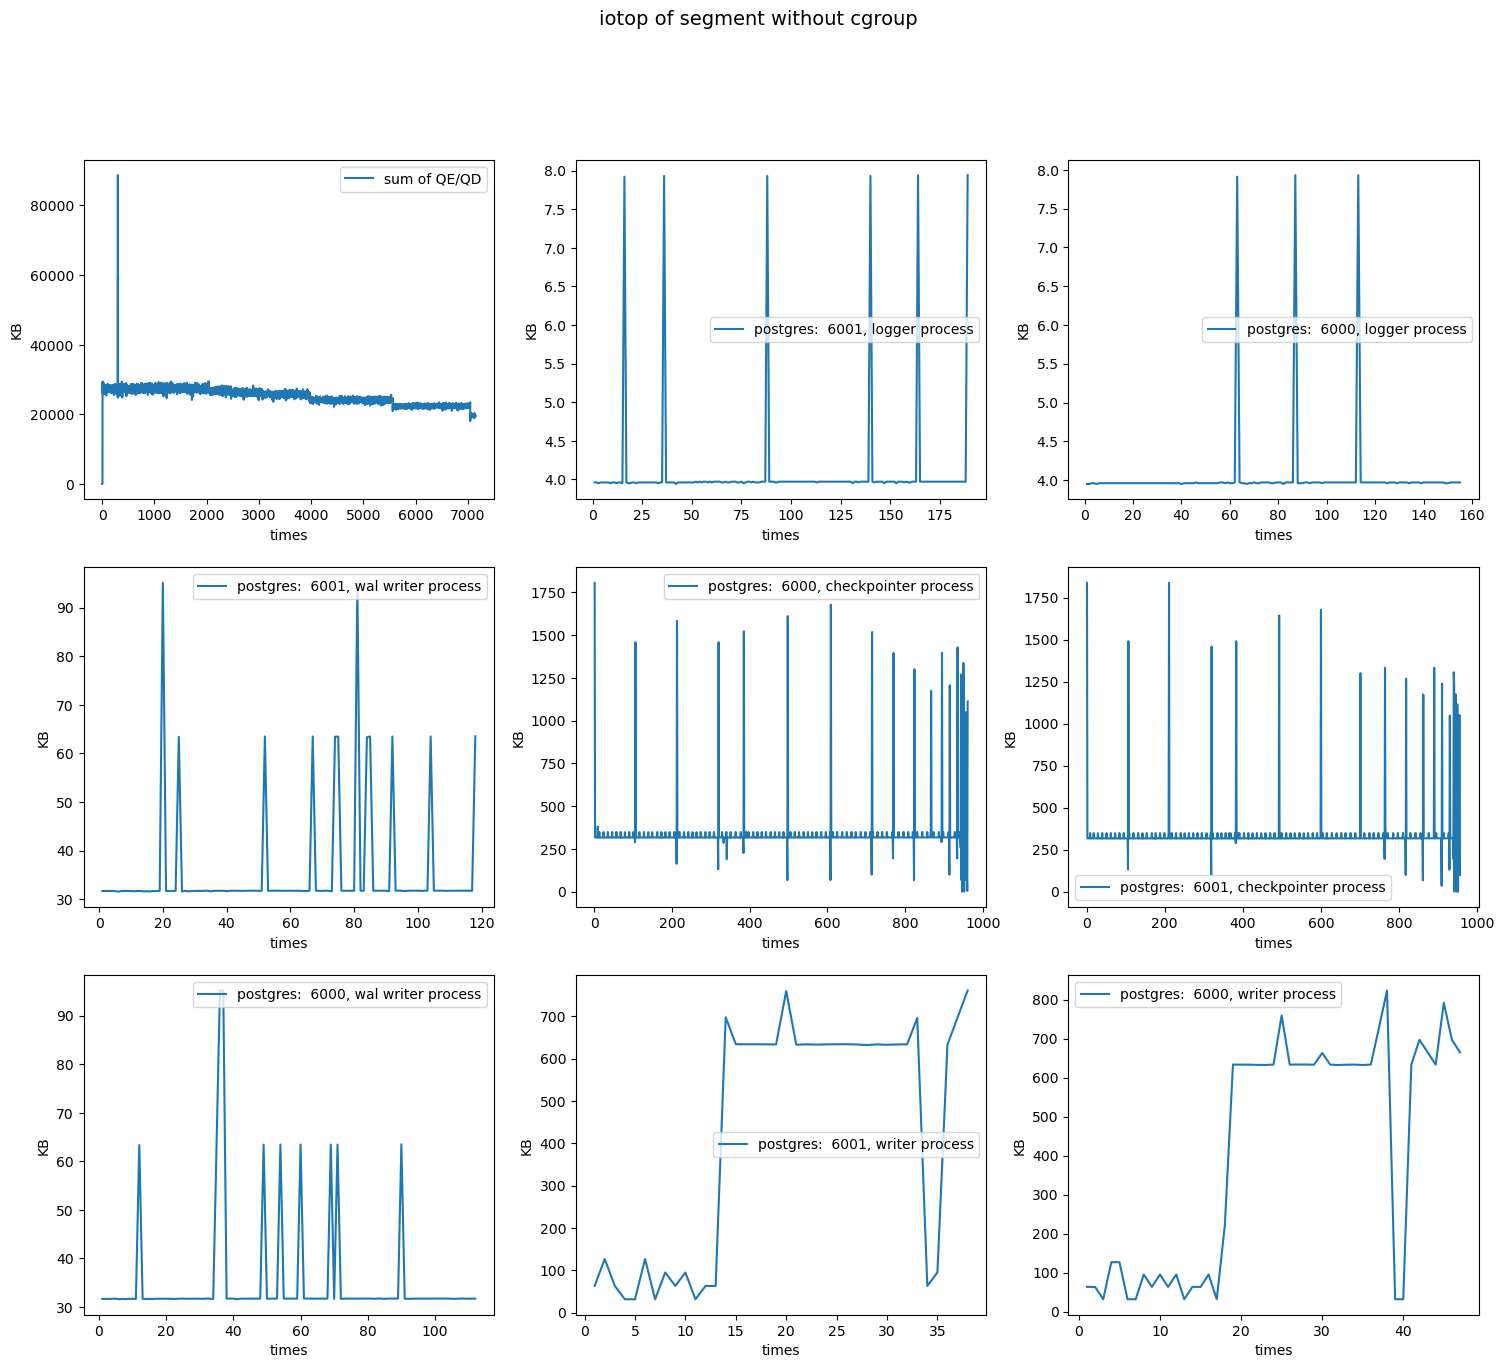

In [52]:
# plot iotop related figure
for dir in working_dirs:
    plot_iotop_per_process(dir[0], dir[1])

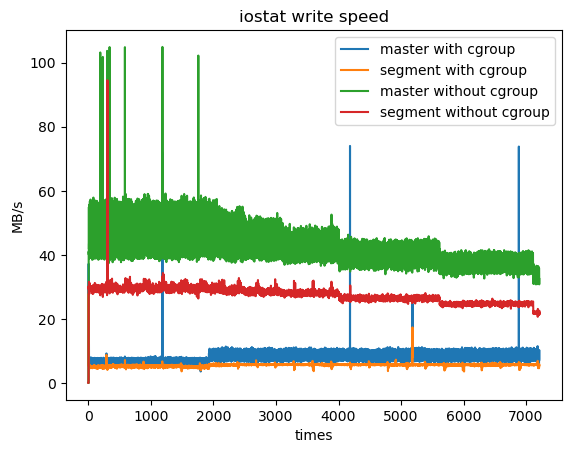

In [53]:
plot_iostat_figure(working_dirs)

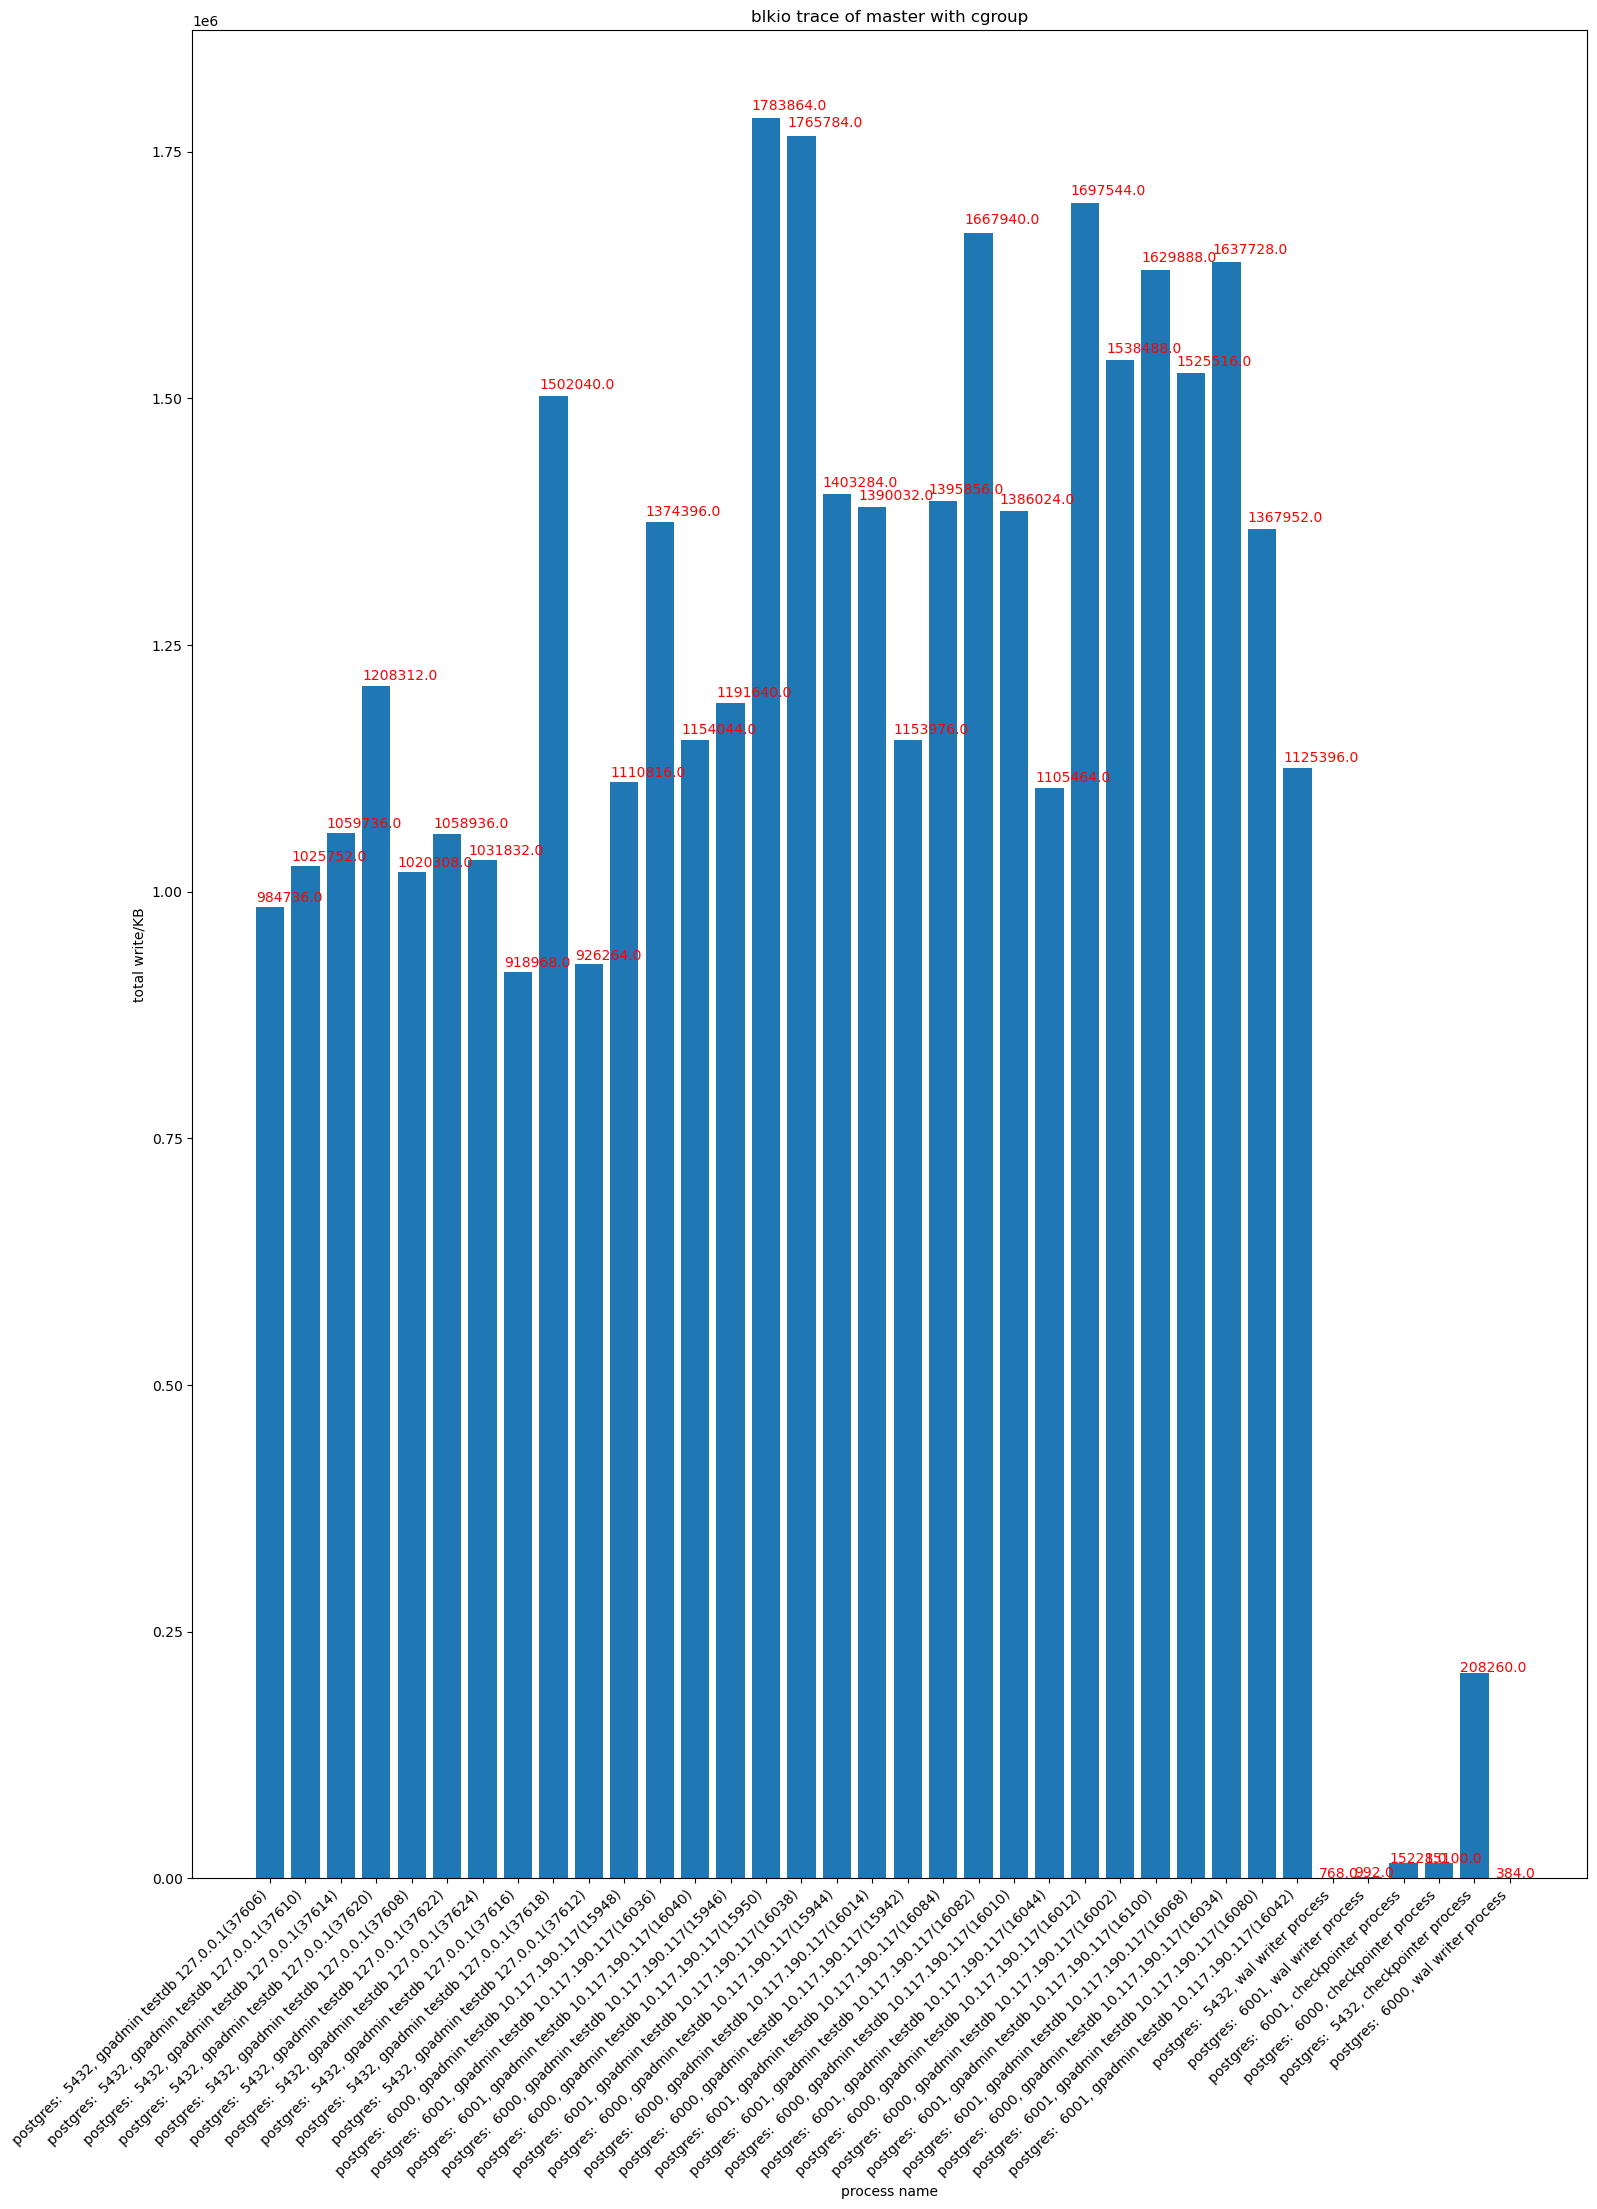

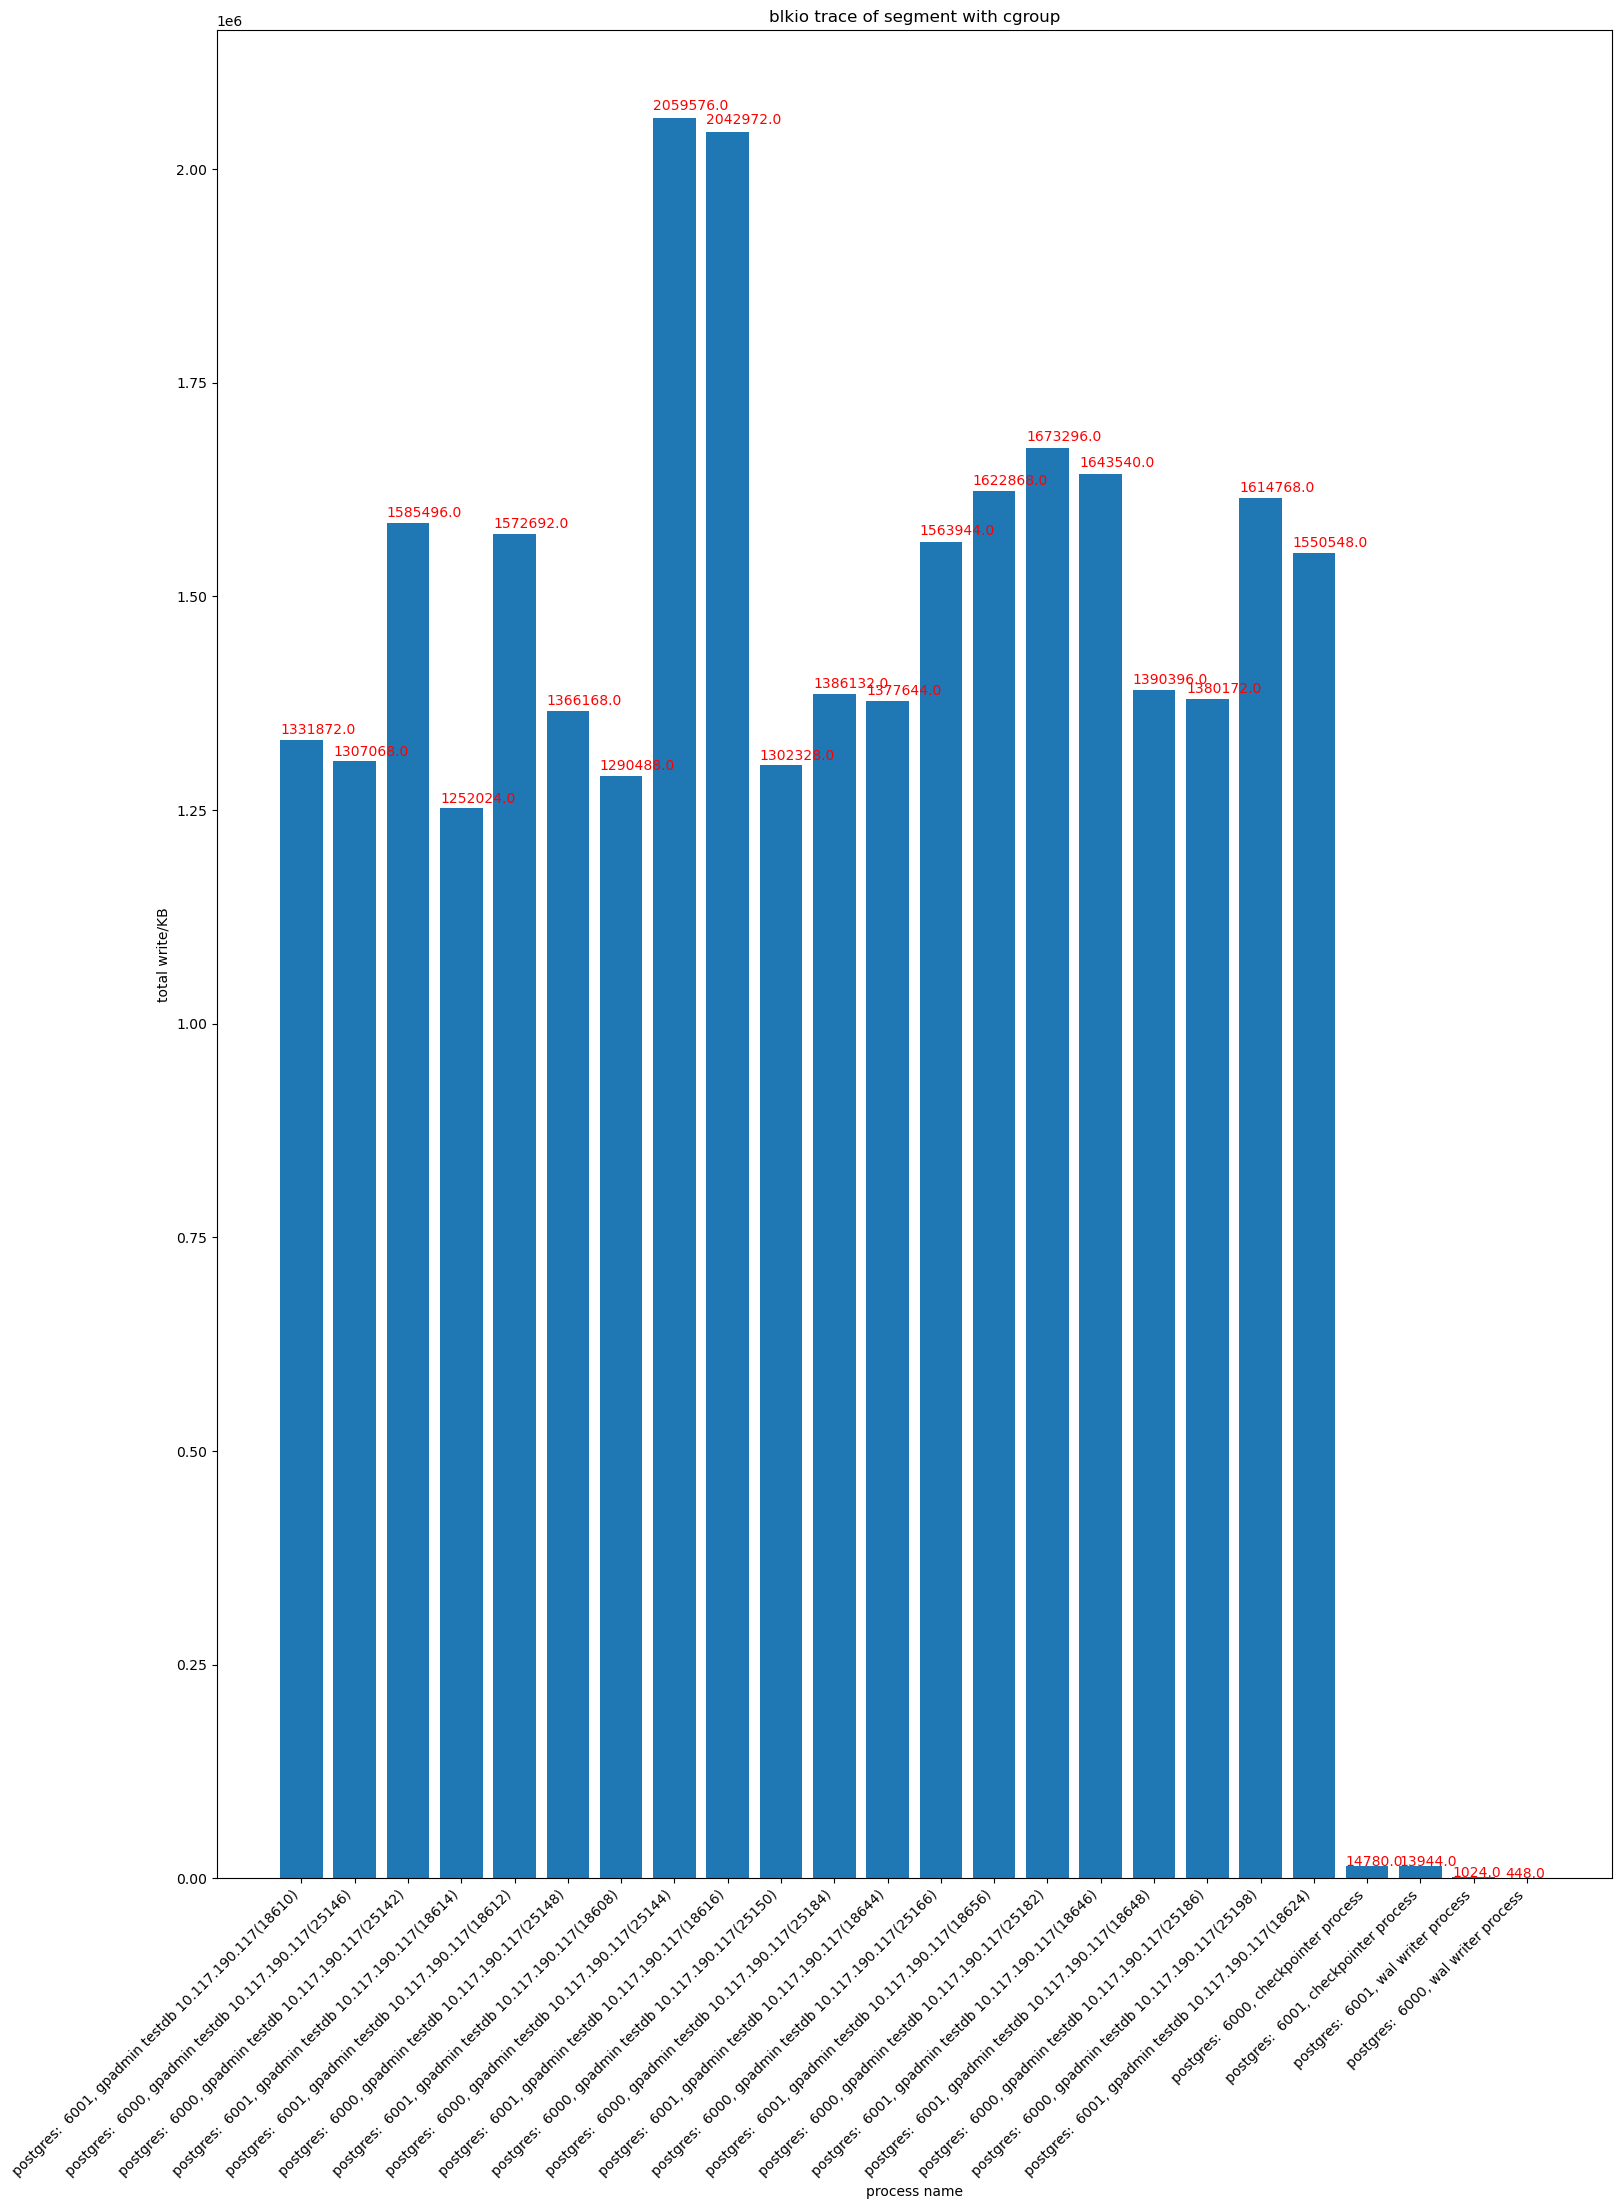

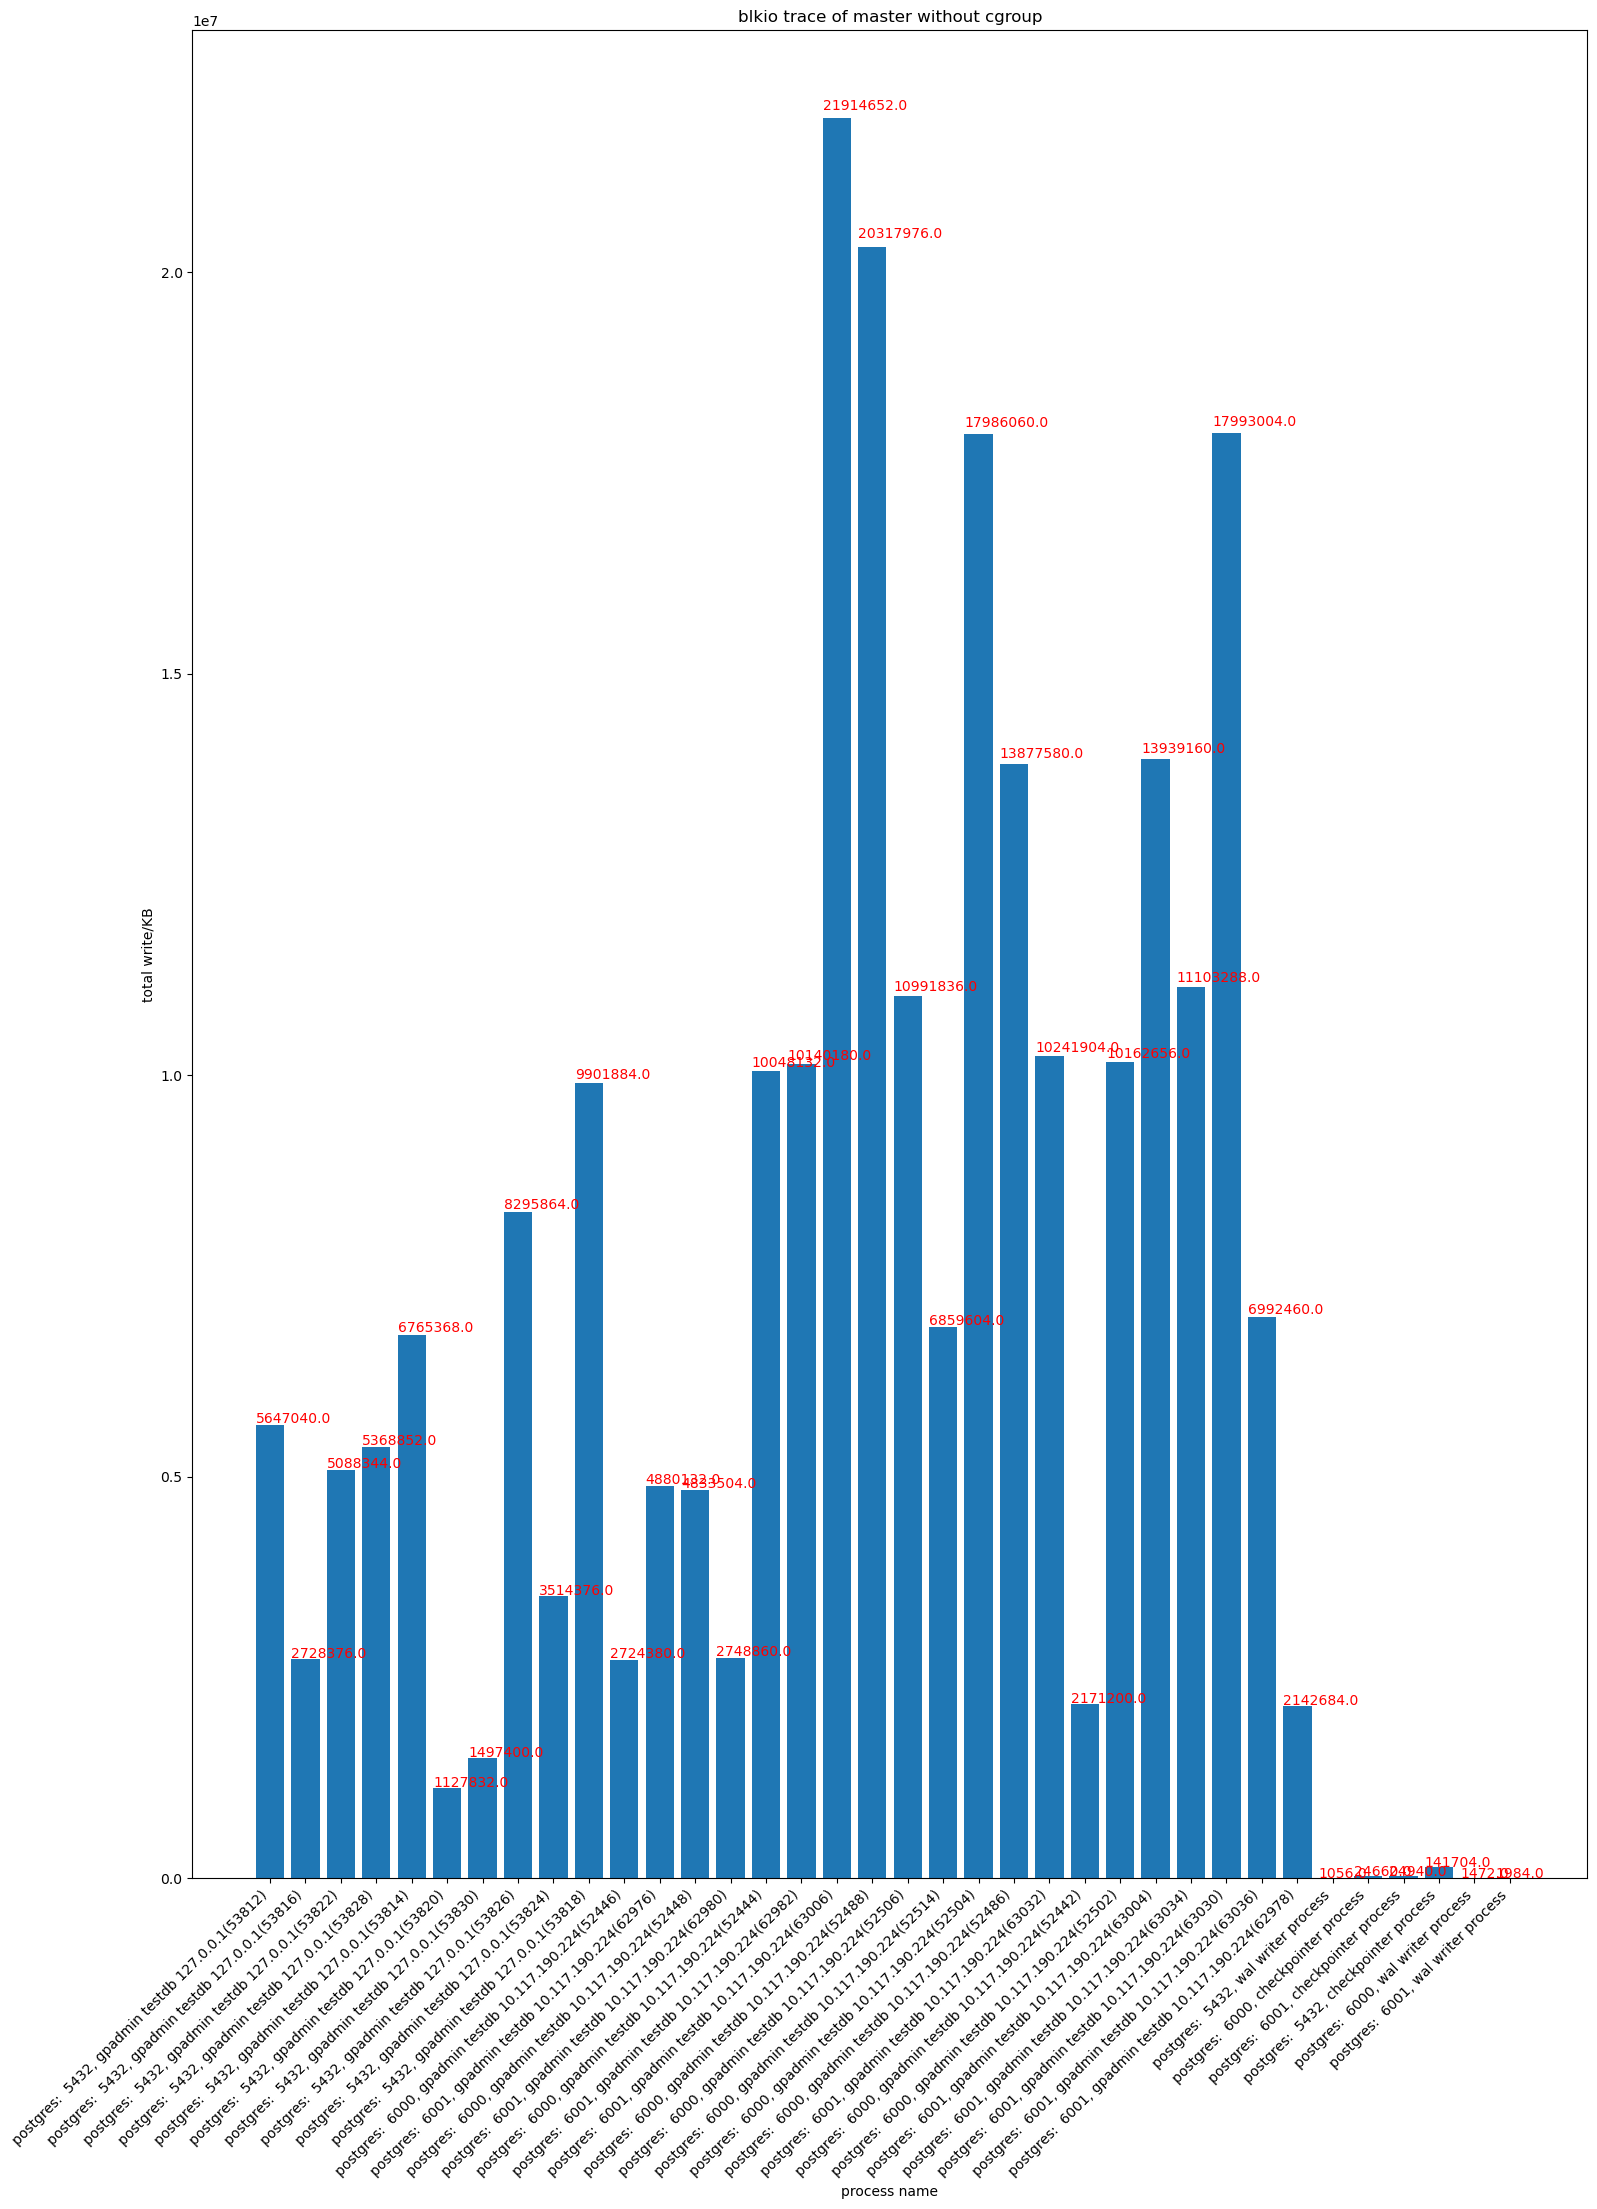

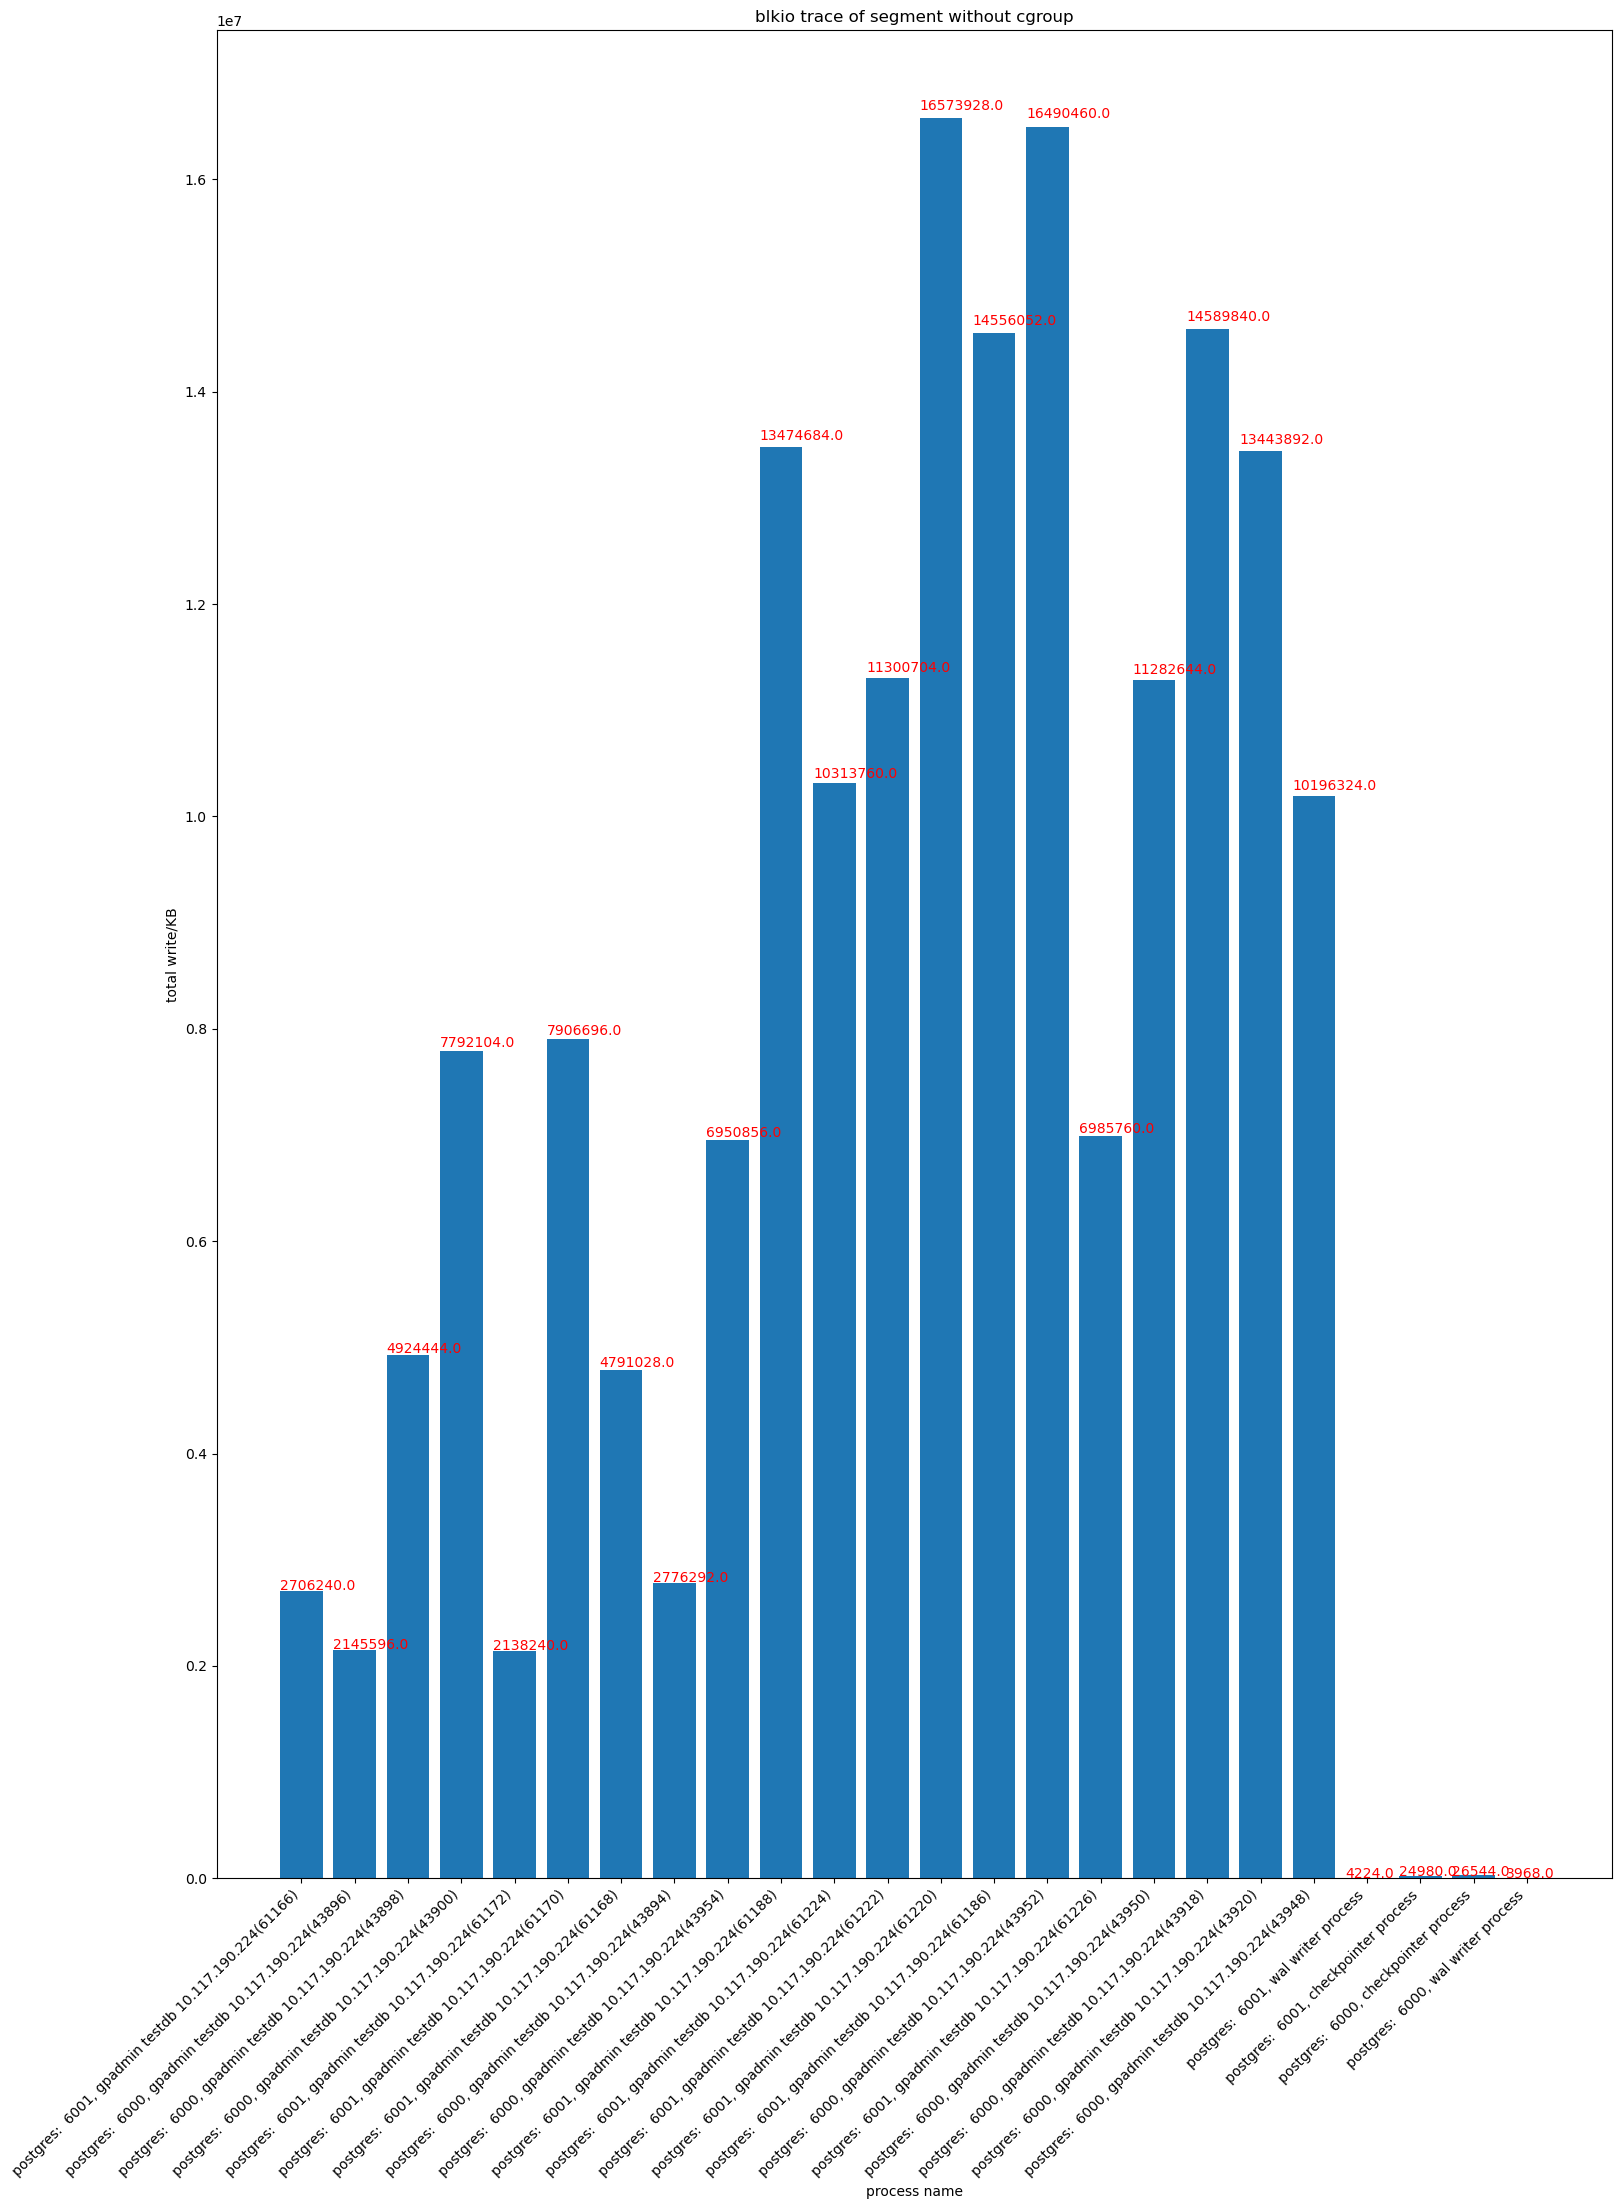

In [59]:
for dir in working_dirs:
    plot_blktrace_data(dir[0], dir[1])